In [32]:
import copy
import os
import sys

import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import tensorflow as tf

from deepcell.applications import NuclearSegmentation, CellTracking
from deepcell_tracking.trk_io import load_trks

sys.path.append('/notebooks/benchmarking')
import utils

In [2]:
source_data = '../data/tracking/test.trks'
        
model_urls = {
    'NuclearSegmentation': 'https://deepcell-data.s3-us-west-1.amazonaws.com/saved-models/NuclearSegmentation-75.tar.gz',
    'NuclearTrackingNE': 'https://deepcell-data.s3-us-west-1.amazonaws.com/saved-models/NuclearTrackingNE-75.tar.gz',
    'NuclearTrackingInf': 'https://deepcell-data.s3-us-west-1.amazonaws.com/saved-models/NuclearTrackingInf-75.tar.gz'
}

In [4]:
# Load test data
data = load_trks(source_data)

In [5]:
# Download and load each model
models = {}
for m, url in model_urls.items():
    archive_path = tf.keras.utils.get_file(f'{m}.tgz', url, extract=True, cache_subdir='models')
    model_path = os.path.splitext(archive_path)[0]
    model = tf.keras.models.load_model(model_path)
    models[m] = model

450641920/450633493 [==============================] - 130s 0us/step


2023-07-10 19:03:48.116990: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 19:03:48.778466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1


548864/538726 [==============================] - 0s 0us/step


In [6]:
# Load segmentation and tracking applications
app_seg = NuclearSegmentation(models['NuclearSegmentation'])
app_trk = CellTracking(models['NuclearTrackingInf'], models['NuclearTrackingNE'])

In [7]:
preds = {}
for batch_no in range(len(data['lineages'])):
    print(batch_no)
    
    # Pull out relevant data for this batch
    X = data['X'][batch_no]
    y = data['y'][batch_no]
    lineage = data['lineages'][batch_no]
    
    # Correct discontiguous tracks, which are not allowed by CTC
    y, lineage = utils.convert_to_contiguous(y, lineage)

    # Determine position of zero padding for removal
    slc = utils.find_zero_padding(X)
    X = X[slc]
    y = y[slc]

    # Determine which frames are zero padding
    frames = np.sum(y, axis=(1,2)) # True if image not blank
    good_frames = np.where(frames)[0]
    X = X[:len(good_frames)]
    y = y[:len(good_frames)]
    
    # Generate tracks on predicted segmentations
    y_pred = app_seg.predict(X)
    track_pred = app_trk.track(X, y_pred)
    track_pred['y_tracked'], track_pred['tracks'] = utils.convert_to_contiguous(track_pred['y_tracked'], track_pred['tracks'])
    preds[batch_no] = track_pred

2


2023-07-10 19:05:00.497634: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


# Plotting

In [8]:
def shuffle_colors(ymax, cmap):
    cmap = mpl.colormaps[cmap].resampled(ymax)
    nmap = cmap(range(ymax))
    np.random.shuffle(nmap)
    cmap = ListedColormap(nmap)
    cmap.set_bad('black')
    return cmap

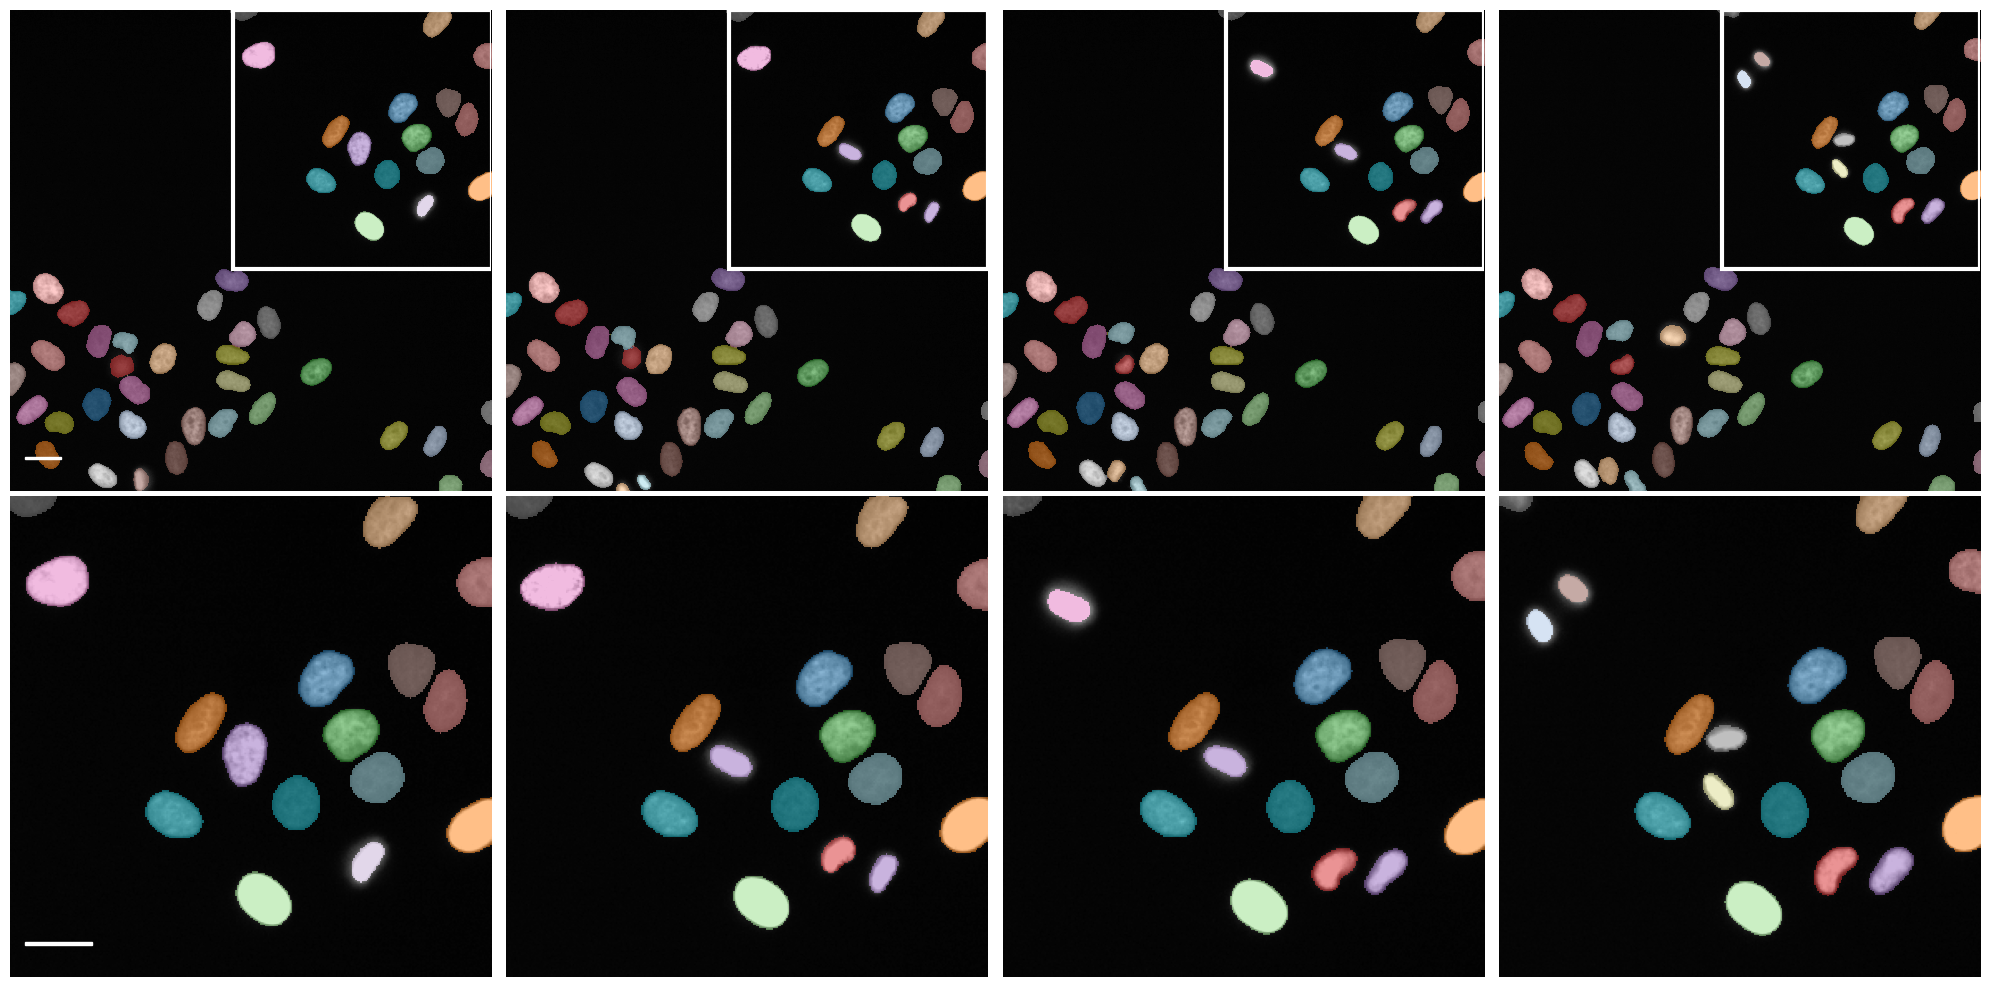

In [49]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
y = preds[2]['y_tracked']
x = preds[2]['X']
yy = copy.deepcopy(y)
yy = np.ma.masked_equal(yy, 0)

# Crop coordinates
x1 = 250
x2 = 540
y1 = 0
y2 = 290

ymax = np.max(y)
cmap = shuffle_colors(ymax, 'tab20')

for axi, t in enumerate(range(16, 28, 3)):
    # Plot the full field of view
    axes[0, axi].imshow(x[t,...,0], cmap='Greys_r', vmax=3000)
    axes[0, axi].imshow(yy[t,...,0], cmap=cmap, alpha=0.5, vmax=ymax)
    axes[0, axi].axis('off')
    
    # Plot the crop box
    rect = patches.Rectangle((x1, y2), (x2-x1), -(y2-y1), linewidth=3, edgecolor='w', facecolor='none')
    axes[0, axi].add_patch(rect)
    
    # Plot the zoom
    axes[1, axi].imshow(x[t, y1:y2, x1:x2, 0], cmap='Greys_r', vmax=3000)
    axes[1, axi].imshow(yy[t, y1:y2, x1:x2, 0], cmap=cmap, alpha=0.5, vmax=ymax)
    axes[1, axi].axis('off')

    

plt.tight_layout()

scalebar = AnchoredSizeBar(axes[0,0].transData,
                           40, # 0.65 mpp, 26 um
                           '', 
                           'lower left', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=2)
axes[0,0].add_artist(scalebar)

scalebar = AnchoredSizeBar(axes[1,0].transData,
                           40, # 0.65 mpp, 26 um
                           '', 
                           'lower left', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=2)
axes[1,0].add_artist(scalebar)
    
fig.savefig('montage.tif')

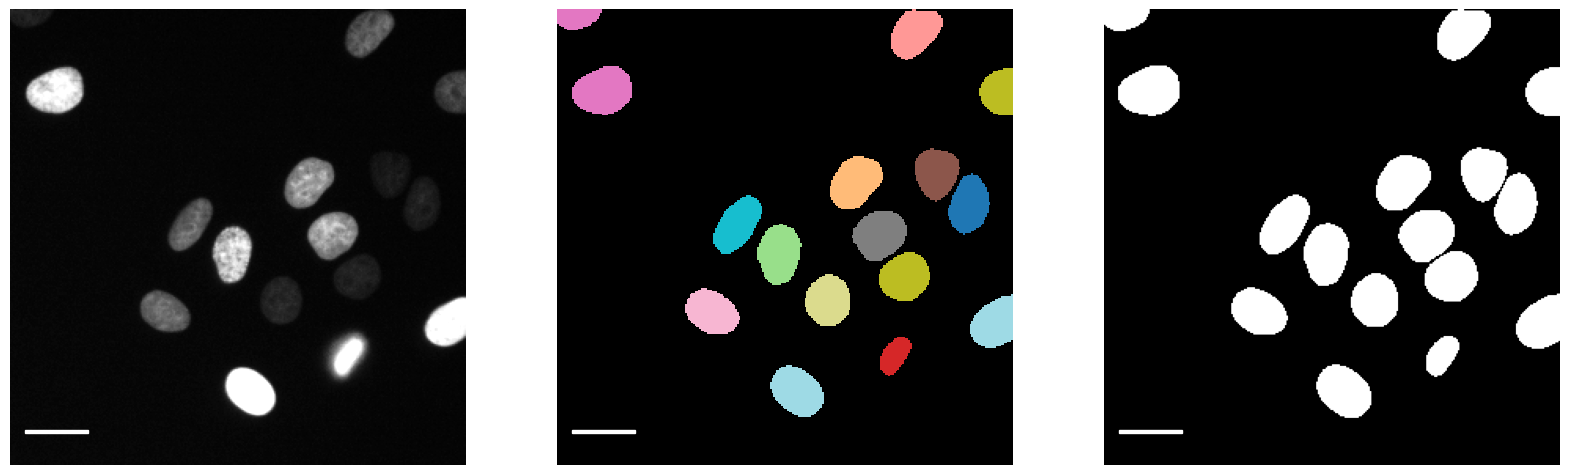

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
t = 16
slc = (t, slice(0, 290), slice(250, 540), 0)

cmap = shuffle_colors(ymax, 'tab20')

ax[0].imshow(x[slc],cmap='Greys_r', vmax=7)
ax[0].axis('off')
ax[1].imshow(yy[slc], cmap=cmap,  vmax=ymax)
ax[1].axis('off')
ax[2].imshow(y[slc]!=0, cmap='Greys_r')
ax[2].axis('off')

for i in range(3):
    scalebar = AnchoredSizeBar(ax[i].transData,
                               40, # 0.65 mpp, 26 um
                               '', 
                               'lower left', 
                               pad=1,
                               color='white',
                               frameon=False,
                               size_vertical=2)
    ax[i].add_artist(scalebar)

fig.savefig('sample.tif')